# INTRODUCCIÓN AL ANÁLISIS EXPLORATORIO DE TEXTO

## ANÁLISIS DE CONTENIDO

El análisis de contenido es una herramienta no intrusiva y que no tiene un impacto en como las personas se comportan. Describe como usar el libro como guía en un curso dependiendo el enfoque. Parte del conocimiento de expertos que pueden extraer el significado de los textos. 

Las computadoras pueden ayudar, pero el ejercicio analítico sigue siendo del investigador.

### _**"Prácticamente todas las disciplinas dentro del espectro completo de las humanidades y las ciencias sociales, incluidas aquellas que buscan mejorar las condiciones políticas y sociales de vida, se preocupan por las funciones y efectos de símbolos, significados y mensajes. En los últimos años, el surgimiento de la sociedad de la información ha desplazado a la minucias de comunicación (textos, contextos, imágenes, interfaces y, sobre todo, información) en el centro mismo de los intentos de los investigadores por lograr la autocomprensión".**_
- Krippendorff, 2019

El análisis de contenido nace de una intención de identificar significado de los mensajes. El contenido de análisis es un técnica de investigación replicable y que permite llegar a inferencias validas del texto en base a su contexto.

### _**"Los análisis de contenido tienen más éxito cuando se centran en hechos que se constituyen en el lenguaje, en los usos de los mismos textos que los analistas de contenido están analizando".**_
- Krippendorff, 2019

Nelson propone en su artículo un nuevo diseño de investigación iterativo en el que se mezcla técnicas computacionales con abordajes cualitativos para fortalecer los procesos de investigación social. El diseño consiste en 3 pasos iterativos moviendose entre herramientas computacionales y cualitativas para fortalecer los resultados. En la sesión de hoy utilizaremos herramientas que nos permiten explorar el contenido para identificar ideas en el contenido.  Utilizaremos la base de datos de discursos de la casa de los comunes en el Reino Unido. 

## IMPORTACIÓN DE HERRAMIENTAS

In [3]:
import pickle
from pprint import pprint
import pandas as pd
pd.set_option("display.notebook_repr_html", False)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from dcss.text import bigram_process, preprocess, bow_to_df
from dcss.plotting import format_axes_commas, custom_seaborn
from dcss.utils import sparse_groupby
custom_seaborn()
import spacy
nlp = spacy.load('en_core_web_sm')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import scipy

In [4]:
columns = ['speech', 'speakername', 'party', 'constituency', 'year']
uk_df = pd.read_csv("../data/hansard-speeches-v301.csv")
uk_df.dropna(subset = ['party', 'speakername', 'speech'],inplace=True)
uk_df = uk_df.query('year > 2016')
uk_df['party'].value_counts()

Conservative                         1875
Scottish National Party              1768
Liberal Democrat                     1759
Labour                               1542
Democratic Unionist Party             961
Independent                           483
Labour (Co-op)                        341
Plaid Cymru                           247
Green Party                            96
The Independent Group for Change       39
Social Democratic & Labour Party       37
Ulster Unionist Party                  29
Change UK - The Independent Group      28
UK Independence Party                   3
Alliance                                1
Name: party, dtype: int64

In [5]:
parties_keep = [
    'Conservative',
    'Labour',
    'Scottish National Party',
    'Labour (Co-op)',
    'Liberal Democrat',
    'Democratic Unionist Party',
    'Plaid Cymru',
    'Green Party'
]
party_subset = uk_df[uk_df['party'].isin(parties_keep)].copy()
party_subset.reset_index(drop=True, inplace=True)
total_speech_counts = party_subset['party'].value_counts()
total_speech_counts

Conservative                 1875
Scottish National Party      1768
Liberal Democrat             1759
Labour                       1542
Democratic Unionist Party     961
Labour (Co-op)                341
Plaid Cymru                   247
Green Party                    96
Name: party, dtype: int64

In [6]:
sampled_speeches = party_subset.groupby('party').sample(replace=False, frac=.3, random_state=23)
len(sampled_speeches)

2576

In [7]:
with open('../data/pickles/sampled_british_hansard_speeches.pkl', 'wb') as fp:
    pickle.dump(sampled_speeches, fp)
sampled_speech_counts = sampled_speeches['party'].value_counts()
sample_sizes = pd.DataFrame(zip(total_speech_counts,sampled_speech_counts), columns=['Total', 'Sample'], index=parties_keep)

In [8]:
sampled_speeches['speech_len'] = sampled_speeches['speech'].apply(lambda x: len(x.split(" ")))

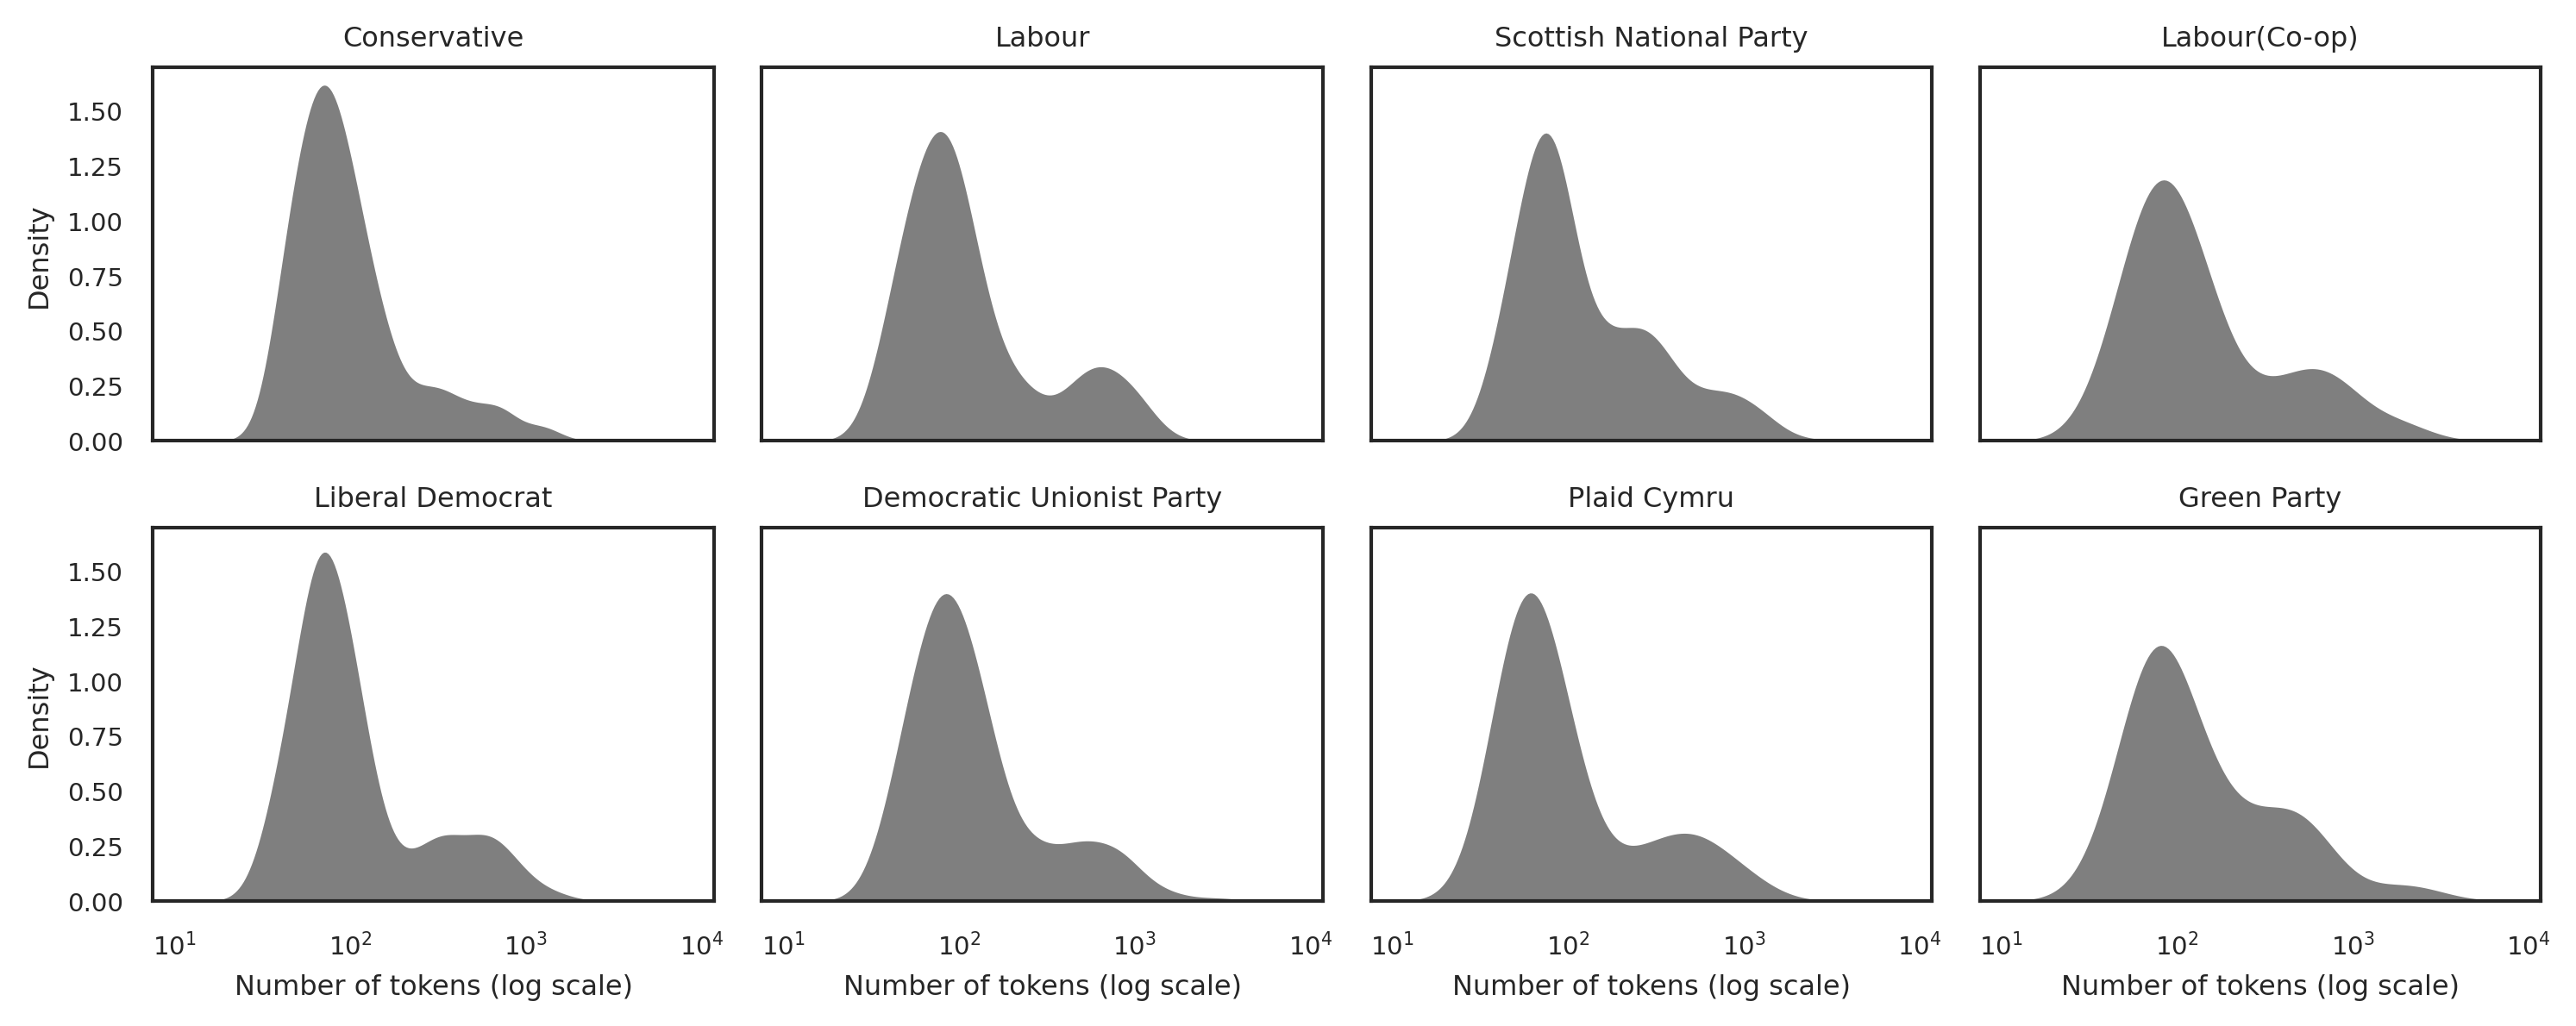

In [9]:
parties = sampled_speeches.groupby('party')
def party_subplot(subgroup, title, position):
    sns.kdeplot(ax = position, data=subgroup, x='speech_len', log_scale=True, fill=True, alpha=.5, linewidth=0, color='black') 
    position.set(xlabel='Number of tokens (log scale)', title=title)
fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 4))
    
party_subplot(parties.get_group('Conservative'), 'Conservative', ax[0,0])
party_subplot(parties.get_group('Labour'), 'Labour', ax[0,1])
party_subplot(parties.get_group('Scottish National Party'), 'Scottish National Party', ax[0,2])
party_subplot(parties.get_group('Labour (Co-op)'), 'Labour(Co-op)', ax[0,3])
party_subplot(parties.get_group('Liberal Democrat'),'Liberal Democrat', ax[1,0])
party_subplot(parties.get_group('Democratic Unionist Party'), 'Democratic Unionist Party', ax[1,1])
party_subplot(parties.get_group('Plaid Cymru'), 'Plaid Cymru', ax[1,2])
party_subplot(parties.get_group('Green Party'), 'Green Party', ax[1,3])

plt.tight_layout()
plt.show()

In [10]:
parties['speech_len'].median()

party
Conservative                  82.0
Democratic Unionist Party     99.0
Green Party                   91.0
Labour                        91.0
Labour (Co-op)               105.0
Liberal Democrat              83.0
Plaid Cymru                   69.0
Scottish National Party       93.0
Name: speech_len, dtype: float64

In [11]:
bigram_model, preprocessed = preprocess(sampled_speeches['speech'], nlp=nlp, bigrams=True, detokenize=True, n_process=4)
len(preprocessed)

2576

In [12]:
with open('../data/pickles/processed_sample_british_party_subset_hansards.pkl', 'wb') as fp: 
    pickle.dump(preprocessed, fp)
with open('../data/pickles/sample_british_party_subset_hansard_bigram_model.pkl', 'wb') as fp: 
    pickle.dump(bigram_model, fp)
with open('../data/pickles/processed_sample_british_party_subset_hansards.pkl', 'rb') as fp:
    preprocessed = pickle.load(fp)

In [13]:
sampled_speeches.iloc[700]['speech']

'May I remind the Leader of the House that the outcome of the England-Ireland match could mean a great deal in respect of the confidence and supply motion?  [Laughter.] I jest, of course.Let me now raise a very serious matter. Last weekend, during Sunday mass, a Roman Catholic cathedral in the Philippines was struck by horror and tragedy when two bombs exploded, killing at least 20 people and wounding more than 100. Responsibility for that devastating attack, which killed both civilians and some police officers who were trying to protect them, was claimed by Daesh.Across the world, terrorists are picking on, attacking and killing those who are worshipping their God in their place of worship. Will the Leader of the House agree to arrange a statement or a debate on this ongoing and global terrorist violence?'

In [14]:
sampled_speeches['preprocessed'] = preprocessed
sampled_speeches.iloc[700]['preprocessed']

'leader house outcome england ireland match great deal respect confidence supply motion laughter course matter weekend sunday mass roman_catholic cathedral philippine horror tragedy bomb people responsibility devastating attack civilian police officer daesh world terrorist god place worship leader house statement debate ongoing global terrorist violence'

In [15]:
count_vectorizer = CountVectorizer(max_df=.1, min_df=3, strip_accents='ascii')

In [16]:
count_matrix = count_vectorizer.fit_transform(preprocessed)
vocabulary = count_vectorizer.get_feature_names_out()
count_matrix.shape

(2576, 3713)

In [18]:
with open('../data/pickles/brit_hansards_sample_party_subset_count_matrix.pkl', 'wb') as fp:
    pickle.dump(count_matrix, fp)
with open('../data/pickles/brit_hansards_sample_party_subset_vocabulary.pkl', 'wb') as fp:
    pickle.dump(vocabulary, fp)

In [20]:
count_data = pd.DataFrame.sparse.from_spmatrix(count_matrix)
count_data.columns = vocabulary
count_data.index = sampled_speeches['party']
count_data.shape

(2576, 3713)

In [21]:
print('sparse size: ' + str(count_data.memory_usage().sum()/1048576) + "MB")
print('sparse density: ' + str(count_data.sparse.density))

sparse size: 0.8612747192382812MB
sparse density: 0.007688907364254851


In [22]:
count_data_d = count_data.sparse.to_dense()
print('tamaño de la densidad: ' + str(count_data_d.memory_usage().sum()/1048576) + "MB")

tamaño de la densidad: 72.992431640625MB


In [23]:
party_counts = sparse_groupby(sampled_speeches['party'], count_matrix, vocabulary)
results = party_counts.div(party_counts.sum(axis=1), axis=0)
results_t = results.T
results_t.sample(20, random_state=10061986)

                Conservative  Democratic Unionist Party  Green Party  \
theresa             0.000000                   0.000000     0.000000   
disaster            0.000057                   0.000000     0.000000   
integral            0.000227                   0.000086     0.000000   
cannabis            0.000455                   0.000086     0.000000   
stark_contrast      0.000057                   0.000000     0.000000   
direction           0.000739                   0.000345     0.000682   
erskine             0.000114                   0.000000     0.000000   
minor               0.000000                   0.000086     0.000000   
interface           0.000057                   0.000000     0.000000   
gulf                0.000057                   0.000000     0.000000   
graduate            0.000114                   0.000000     0.000000   
close               0.000682                   0.000259     0.000000   
day                 0.002047                   0.003279     0.00

In [24]:
search_term = 'scotland'

In [25]:
results_t.loc[search_term].sort_values(ascending=False)

Scottish National Party      0.015622
Plaid Cymru                  0.002283
Liberal Democrat             0.001804
Conservative                 0.001592
Democratic Unionist Party    0.001381
Labour (Co-op)               0.000899
Labour                       0.000678
Green Party                  0.000000
Name: scotland, dtype: float64

In [26]:
n_top_words = 5
top_words_per_party = {}

In [27]:
for party in results_t.columns:
    top = results_t[party].nlargest(n_top_words)
    top_words_per_party[party] = list(zip(top.index, top))
for k, v in top_words_per_party.items():
    print(k.upper())
    for each in v:
        print(each)
    print('\n')

CONSERVATIVE
('school', 0.006653019447287615)
('business', 0.006368702376890708)
('child', 0.006084385306493802)
('lady', 0.005174570681223701)
('local', 0.005174570681223701)


DEMOCRATIC UNIONIST PARTY
('northern_ireland', 0.025021570319240724)
('united_kingdom', 0.007333908541846419)
('assembly', 0.006125970664365833)
('decision', 0.0060396893874029335)
('matter', 0.005004314063848145)


GREEN PARTY
('climate', 0.00954328561690525)
('law', 0.00954328561690525)
('action', 0.008861622358554875)
('group', 0.008861622358554875)
('system', 0.008861622358554875)


LABOUR
('amendment', 0.006672922531539985)
('child', 0.0059430716296528)
('day', 0.005630278385986863)
('labour', 0.004639766447711396)
('family', 0.00458763424043374)


LABOUR (CO-OP)
('young', 0.009713977334052886)
('committee', 0.007375427235114229)
('health', 0.007015650296815974)
('legislation', 0.006835761827666847)
('community', 0.0061162079510703364)


LIBERAL DEMOCRAT
('child', 0.0069518149012948414)
('home', 0.00541286

In [29]:
diff_con_snp = results_t['Conservative'] - results_t['Scottish National Party']
diff_con_snp.sort_values(ascending=False, inplace=True)
con_not_snp = diff_con_snp.head(20)
con_not_snp

school         0.005478
lady           0.004000
local          0.003260
education      0.002699
business       0.002496
police         0.002405
high           0.002377
opportunity    0.002337
council        0.002316
child          0.002081
fire           0.002040
department     0.002012
great          0.001902
safety         0.001823
challenge      0.001799
building       0.001559
support        0.001493
transport      0.001478
labour         0.001470
pupil          0.001448
dtype: float64

In [30]:
lab_not_snp = diff_con_snp.tail(20)
lab_not_snp

situation       -0.001203
single_market   -0.001209
westminster     -0.001209
constituent     -0.001224
cancer          -0.001249
lot             -0.001296
veteran         -0.001322
ayrshire        -0.001392
national        -0.001582
leader          -0.001588
policy          -0.001605
glasgow         -0.001818
day             -0.001913
power           -0.002241
snp             -0.002273
family          -0.002281
tory            -0.002872
parliament      -0.003108
scottish        -0.010903
scotland        -0.014029
dtype: float64

[Text(0.5, 118.74999999999996, '($\\longleftarrow$ Scottish National Party)(Conservative Party $\\longrightarrow$)'),
 Text(-31.50000000000001, 0.5, ''),
 Text(0.5, 1.0, 'Difference of Proportions')]

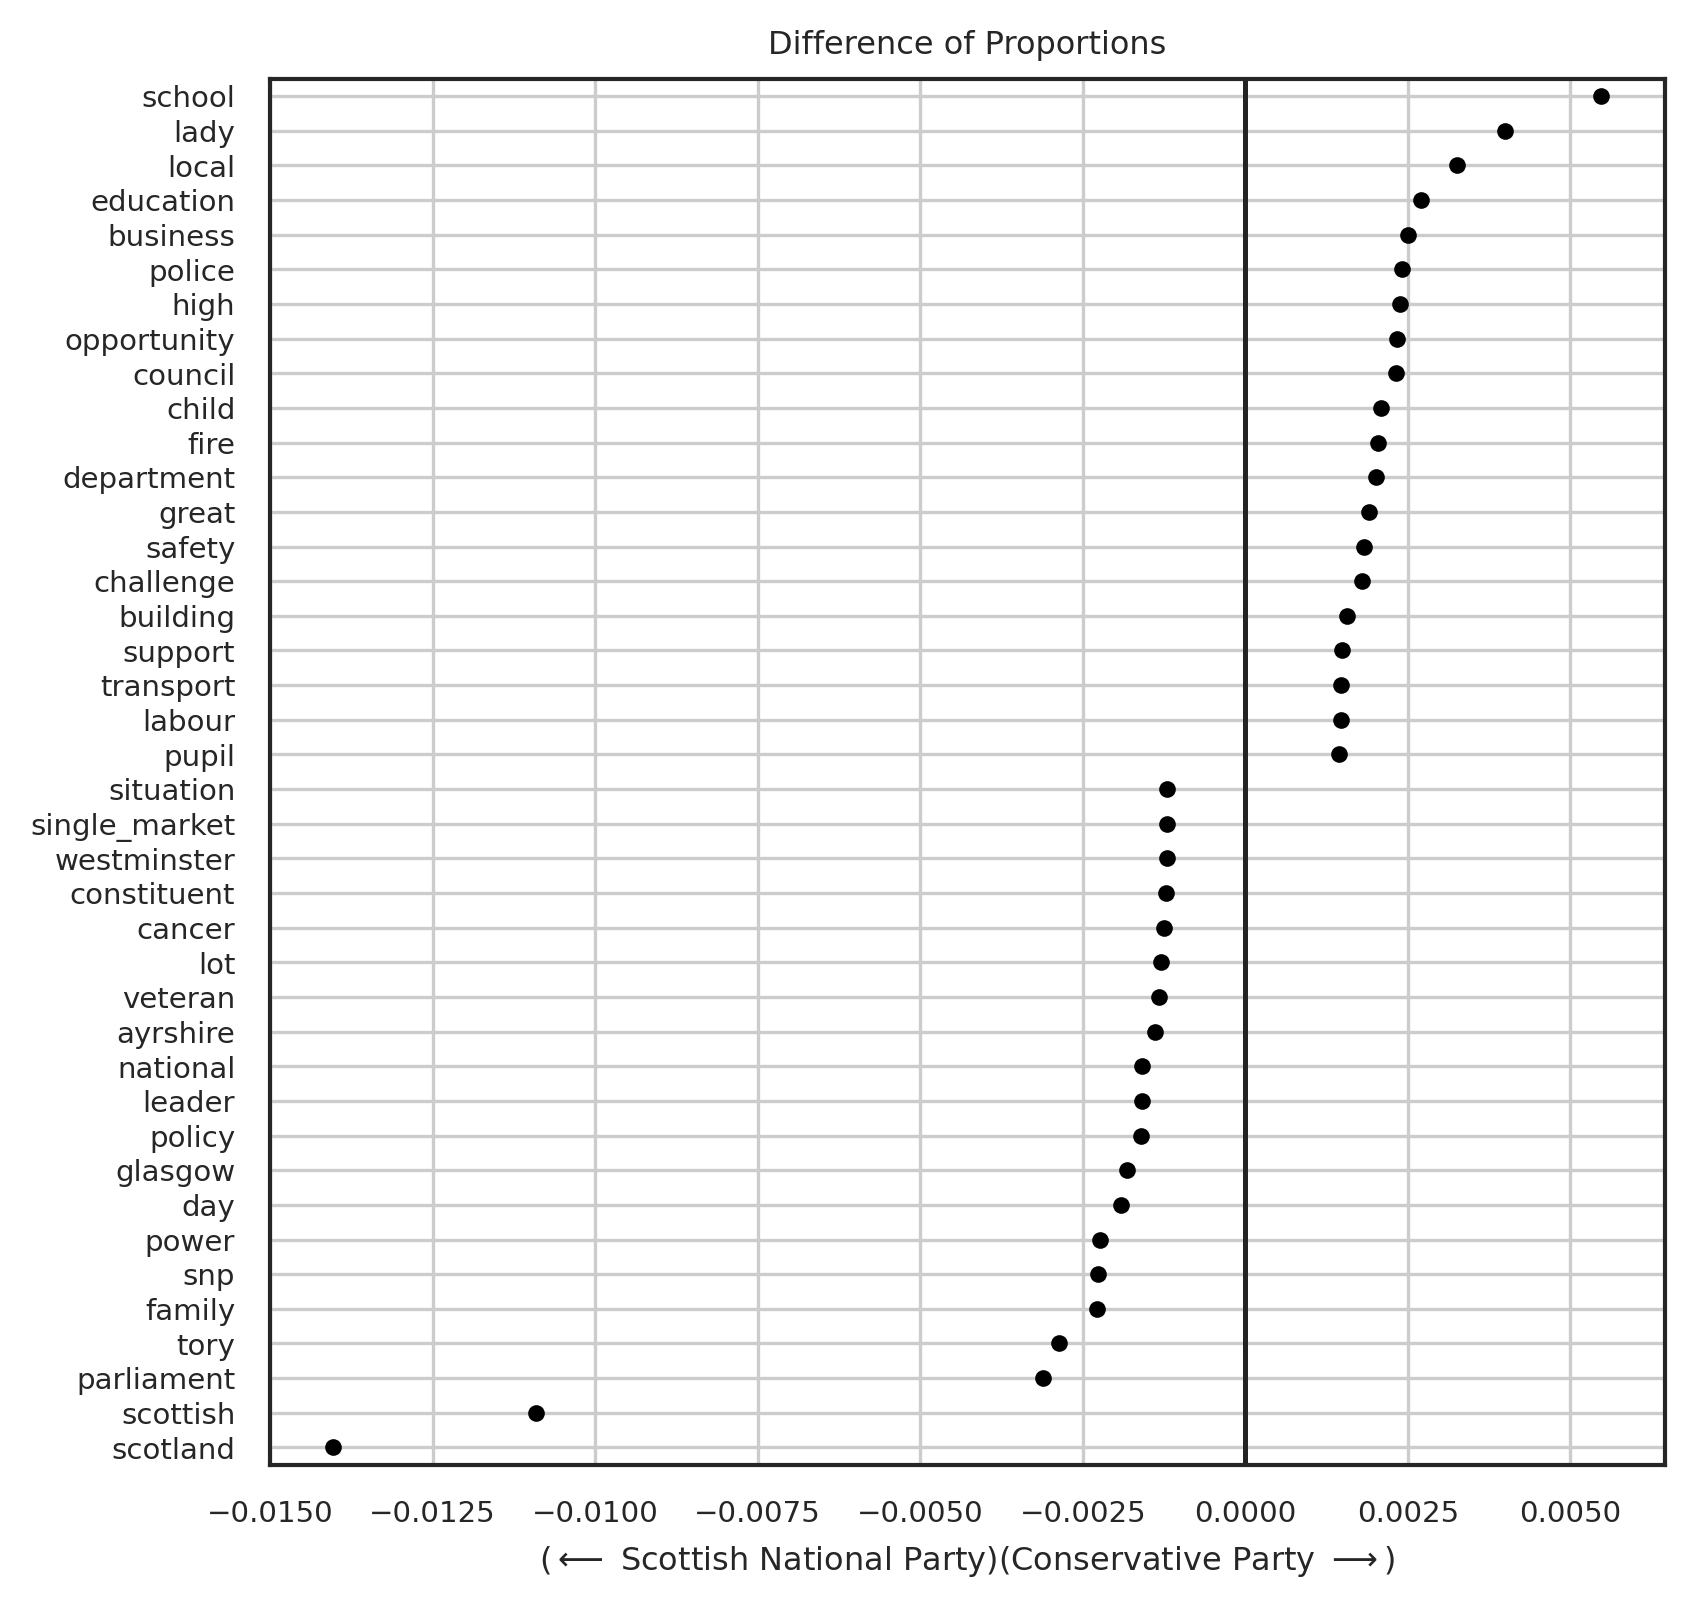

In [33]:
dop = pd.concat([con_not_snp, lab_not_snp])
fig, ax = plt.subplots(figsize = (6, 6))
sns.swarmplot(x=dop, y=dop.index, color='black', size=4)
ax.axvline(0)
plt.grid()
ax.set(xlabel=r'($\longleftarrow$ Scottish National Party)(Conservative Party $\longrightarrow$)', ylabel='', title='Difference of Proportions')